## pipe()
pipe() is a method of chaining functions

### Example 1

In [1]:
import pandas as pd
import numpy as np

# Set seed
np.random.seed(520)

# Create a dataframe
df = pd.DataFrame({
    'name': ['Ted'] * 3 + ['Lisa'] * 3 + ['Sam'] * 3,
    'subject': ['math', 'physics', 'history'] * 3,
    'score': np.random.randint(60, 100, 9)
})

df

,name,subject,score
0,Ted,math,87
1,Ted,physics,80
2,Ted,history,75
3,Lisa,math,79
4,Lisa,physics,78
5,Lisa,history,77
6,Sam,math,85
7,Sam,physics,61
8,Sam,history,88


In [2]:
def get_subject_rank(input_df):
    input_df = input_df.copy()
    input_df['subject_rank'] = (input_df
                                .groupby(['subject'])['score']
                                .rank(ascending=False))
    return input_df

# pipe method
df.pipe(get_subject_rank)

,name,subject,score,subject_rank
0,Ted,math,87,1.0
1,Ted,physics,80,1.0
2,Ted,history,75,3.0
3,Lisa,math,79,3.0
4,Lisa,physics,78,2.0
5,Lisa,history,77,2.0
6,Sam,math,85,2.0
7,Sam,physics,61,3.0
8,Sam,history,88,1.0


### Return pandas series
Pipe can return arbitrary outputs when defined in functions. In the following example, the function returns pandas series once df_or_not = False. Other arguments needs to be specified in the calling in pipe when functions have more than one arguments, also shown in the example below.

In [3]:
def get_subject_rank(input_df, df_or_not=True):
    # Avoid overwrite the original dataframe
    input_df = input_df.copy()
    if df_or_not is True:
        input_df['subject_rank'] = (input_df
                                    .groupby(['subject'])['score']
                                    .rank(ascending=False))
        return input_df
    else:
        output_series = (input_df
                         .groupby(['subject'])['score']
                         .rank(ascending=False))
        return output_series

# pipe method - return arbitary output
df.pipe(get_subject_rank, df_or_not = False)

0    1.0
1    1.0
2    3.0
3    3.0
4    2.0
5    2.0
6    2.0
7    3.0
8    1.0
Name: score, dtype: float64

### Pass argument to function

In [4]:
def add_score(input_df, added_score):
    
    input_df = input_df.copy()
    input_df = input_df.assign(new_score=lambda x: x.score+added_score)
    return input_df

df.pipe(add_score, 2)

,name,subject,score,new_score
0,Ted,math,87,89
1,Ted,physics,80,82
2,Ted,history,75,77
3,Lisa,math,79,81
4,Lisa,physics,78,80
5,Lisa,history,77,79
6,Sam,math,85,87
7,Sam,physics,61,63
8,Sam,history,88,90


#### The two arguments of add_score are swapped with each other. In this case, df is the second argument in the calling. Thus, a tuple - (function, “the argument of data”) - is passed to point out that which argument is the data to apply the function on.

In [5]:
def add_score(added_score, input_df):
    # Avoid overwrite the original dataframe
    input_df = input_df.copy()
    input_df = input_df.assign(new_score=lambda x: x.score+added_score)
    return input_df

df.pipe((add_score, "input_df"), 2)

,name,subject,score,new_score
0,Ted,math,87,89
1,Ted,physics,80,82
2,Ted,history,75,77
3,Lisa,math,79,81
4,Lisa,physics,78,80
5,Lisa,history,77,79
6,Sam,math,85,87
7,Sam,physics,61,63
8,Sam,history,88,90


### Debug in method chaining
Some critics might have concerns that it is hard to debug with long chaining processes due to the lack of intermediate results returned. No worries! In this post, the author had provided a great way to tackle this problem - decorators. A decorators is a function that extends the behavior of wrapped function without explicitly modifying it.

Let’s look into actual examples. By using decorators & logging together, any properties of dataframe can be returned in log files when specified in decorators. Here, shape & columns are returned using log_shape & log_columns. The logging information are also printed below for reference.

In [6]:
from functools import wraps
import logging

logging.basicConfig(filename='pipe.log', level=logging.INFO, format='%(levelname)s-%(message)s')
def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.shape))
        return result
    return wrapper

def log_columns(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.columns))
        return result
    return wrapper

@log_columns
@log_shape
def get_subject_rank(input_df):
    input_df = input_df.copy()
    input_df['subject_rank'] = (input_df
                                .groupby(['subject'])['score']
                                .rank(ascending=False))
    return input_df

@log_columns
@log_shape
def add_score(input_df, added_score):
    input_df = input_df.copy()
    input_df = input_df.assign(new_score=lambda x: x.score+added_score)
    return input_df

(
    df.pipe(get_subject_rank)
      .pipe(add_score, 2)
)

,name,subject,score,subject_rank,new_score
0,Ted,math,87,1.0,89
1,Ted,physics,80,1.0,82
2,Ted,history,75,3.0,77
3,Lisa,math,79,3.0,81
4,Lisa,physics,78,2.0,80
5,Lisa,history,77,2.0,79
6,Sam,math,85,2.0,87
7,Sam,physics,61,3.0,63
8,Sam,history,88,1.0,90


### Example 2

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
original=pd.read_csv("DirectMarketing.csv")

In [57]:
def copy_df(func):
    def wrapper():
        result=func()
        return result.copy()
    return wrapper

In [58]:
@copy_df
def load_data():
    return pd.read_csv("DirectMarketing.csv")

In [59]:
marketing = load_data()
marketing.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,Old,Female,Own,Single,Far,47500,0,High,6,755
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304


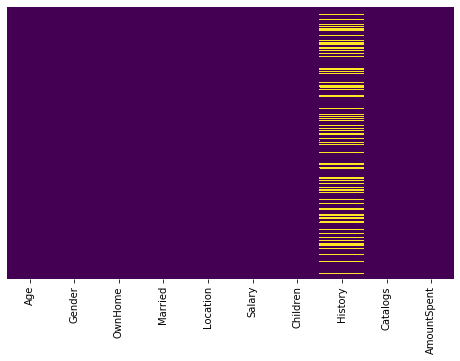

In [60]:
# check missing values first

plt.subplots(figsize=(8,5))

sns.heatmap(marketing.isnull(),
           yticklabels=False,
           cbar=False,
           cmap='viridis')

In [61]:
marketing.isnull().sum()

Age              0
Gender           0
OwnHome          0
Married          0
Location         0
Salary           0
Children         0
History        303
Catalogs         0
AmountSpent      0
dtype: int64

In [62]:
marketing.shape[0]

1000

In [63]:
# drop the column which has two many missing value
# set the threshold to 70% --> keep the column if it has more than 70% of data

In [64]:
thresh=len(marketing)*0.7
print(thresh)
marketing.dropna(axis=1, thresh=thresh, inplace=True)

700.0


In [65]:
marketing.isnull().sum()

Age            0
Gender         0
OwnHome        0
Married        0
Location       0
Salary         0
Children       0
Catalogs       0
AmountSpent    0
dtype: int64

In [66]:
# remove outliers
low_limit, high_limit=marketing.Salary.quantile([0.05, 0.95])
print(low_limit, high_limit)


13695.0 110019.99999999999


In [67]:
marketing_remove_outliers=marketing[marketing.Salary.between(low_limit, high_limit)]

marketing.shape[0]-marketing_remove_outliers.shape[0]


100

#### The dataframe contains many categorical variables. If the number of categories are few compared to the total number values, it is better to use the category data type instead of object. It saves a great amount of memory depending on the data size.

In [68]:
marketing_remove_outliers.select_dtypes(include='object')

,Age,Gender,OwnHome,Married,Location
0,Old,Female,Own,Single,Far
1,Middle,Male,Rent,Single,Close
3,Middle,Male,Own,Married,Close
4,Middle,Female,Own,Single,Close
5,Young,Male,Own,Married,Close
...,...,...,...,...,...
995,Young,Female,Rent,Single,Close
996,Middle,Male,Rent,Single,Far
997,Old,Male,Own,Single,Close
998,Middle,Male,Own,Married,Close


In [69]:
cols=marketing_remove_outliers.select_dtypes(include='object').columns

for col in cols:
    ratio=len(marketing_remove_outliers[col].value_counts())/len(marketing_remove_outliers)
    if ratio<0.05:
        marketing_remove_outliers[col]=marketing_remove_outliers[col].astype('category')

C:\Users\Chul\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
marketing_remove_outliers.dtypes

Age            category
Gender         category
OwnHome        category
Married        category
Location       category
Salary            int64
Children          int64
Catalogs          int64
AmountSpent       int64
dtype: object

In [71]:
def drop_missing(df):
    thresh=len(df)*0.7
    df.dropna(axis=1, thresh=thresh, inplace=True)
    return df

def remove_outliers(df, col_name):
    lower, upper=df[col_name].quantile([0.05, 0.95])
#     lower = np.quantile(df[col_name], 0.05)
#     upper = np.quantile(df[col_name], 0.95)
    
    return df[df[col_name].between(lower, upper, inclusive=True)]

def to_category(df):
    cols=df.select_dtypes(include='object').columns
    for col in cols:
        ratio=len(df[col].value_counts())/len(df)
        if ratio <0.05:
            
            df[col]=df[col].astype('category')
    return df

In [72]:
marketing_cleaned=(marketing.pipe(drop_missing).
                   pipe(remove_outliers, 'Salary').
                   pipe(to_category)
                  )


C:\Users\Chul\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Chul\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
original.shape[0]-marketing_cleaned.shape[0]

100